1. Data Preperation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_excel('heart_disease.xlsx',sheet_name='Heart_disease')  # use the correct path to your Excel file
print(df.head(15))
print(df.columns)

    age     sex               cp  trestbps  chol    fbs           restecg  \
0    63    Male   typical angina       145   233   True    lv hypertrophy   
1    41    Male  atypical angina       135   203  False            normal   
2    57    Male     asymptomatic       140   192  False            normal   
3    52    Male   typical angina       118   186  False    lv hypertrophy   
4    57    Male     asymptomatic       110   201  False            normal   
5    66    Male     asymptomatic       160   228  False    lv hypertrophy   
6    56    Male      non-anginal       130   276  False            normal   
7    48    Male      non-anginal       110   211  False            normal   
8    57    Male  atypical angina       140   260   True            normal   
9    53    Male      non-anginal       155   175   True  st-t abnormality   
10   30  Female   typical angina       170   237  False  st-t abnormality   
11   66  Female   typical angina       150   226  False            normal   

In [3]:
print(df.columns)


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'oldpeak', 'slope', 'thal', 'num'],
      dtype='object')


In [4]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('num', axis=1)

In [5]:
print(df.head())
print(df['target'].value_counts())


   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  target  
0  False      2.3  downsloping  fixed defect       0  
1  False      0.0         flat  fixed defect       0  
2  False      0.4         flat  fixed defect       0  
3  False      0.0         flat  fixed defect       0  
4   True      1.5         flat  fixed defect       0  
target
1    509
0    399
Name: count, dtype: int64


2. Exploratory Data Analysis (EDA)


--- EDA: Checking for Missing Values ---
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
target       0
dtype: int64


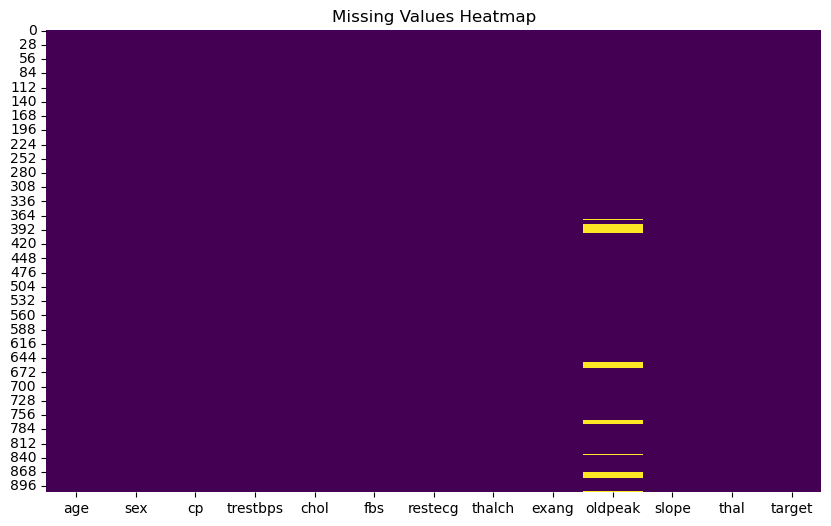


--- EDA: Basic Statistics ---
              age    trestbps        chol      thalch     oldpeak      target
count  908.000000  908.000000  908.000000  908.000000  846.000000  908.000000
mean    53.791850  133.430617  201.484581  135.957048    0.891253    0.560573
std      9.158031   20.401608  112.097949   26.804929    1.093875    0.496591
min     29.000000    0.000000    0.000000   60.000000   -2.600000    0.000000
25%     47.750000  120.000000  176.750000  118.000000    0.000000    0.000000
50%     54.000000  130.000000  224.000000  138.000000    0.500000    1.000000
75%     60.000000  144.000000  270.000000  156.000000    1.500000    1.000000
max     77.000000  200.000000  603.000000  202.000000    6.200000    1.000000

--- EDA: Distribution of Features ---


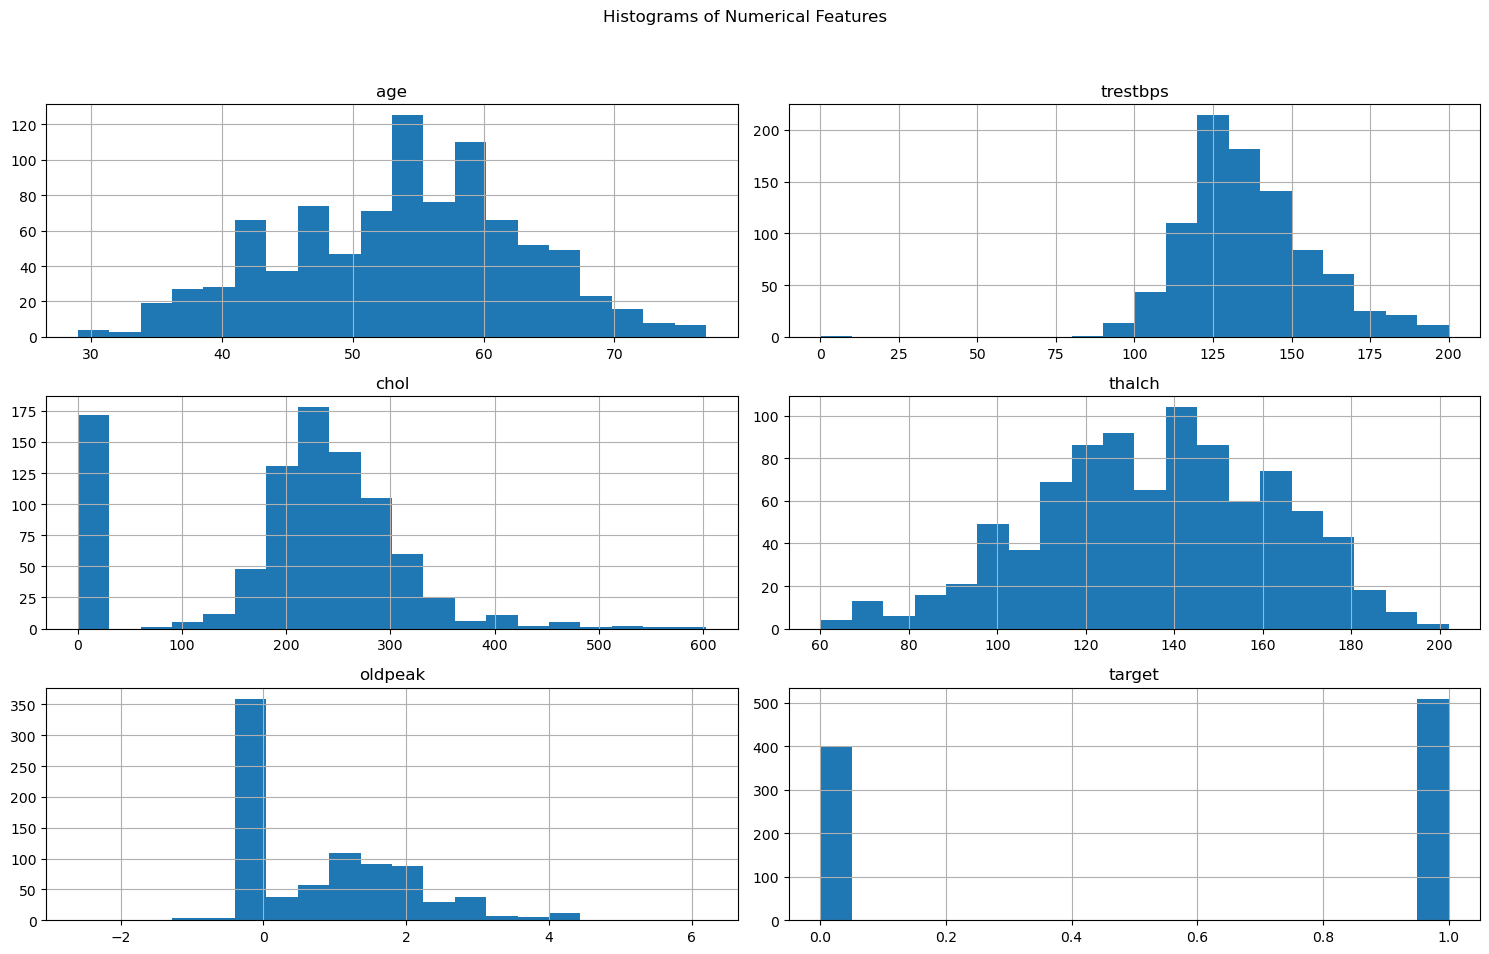

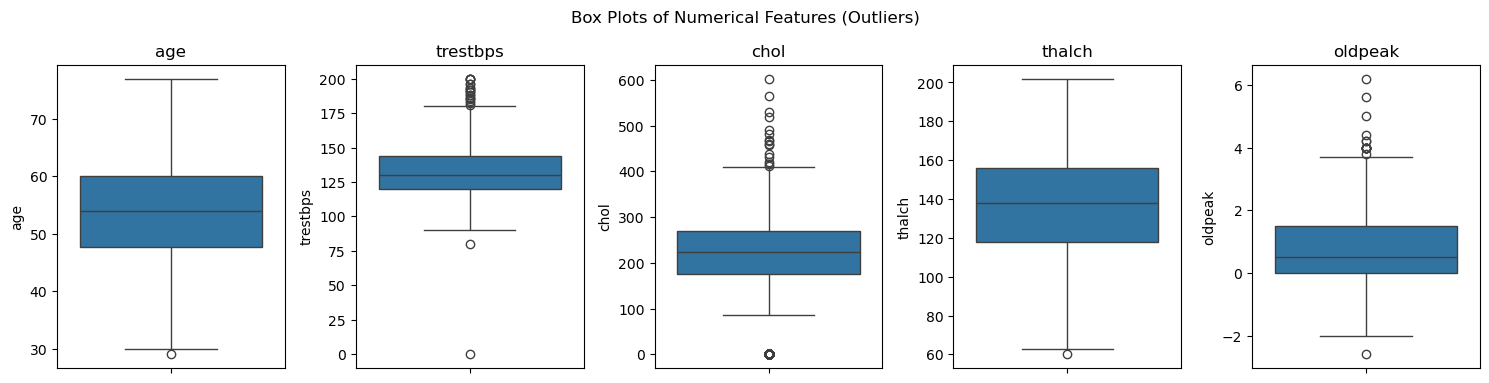


--- EDA: Correlation Matrix ---


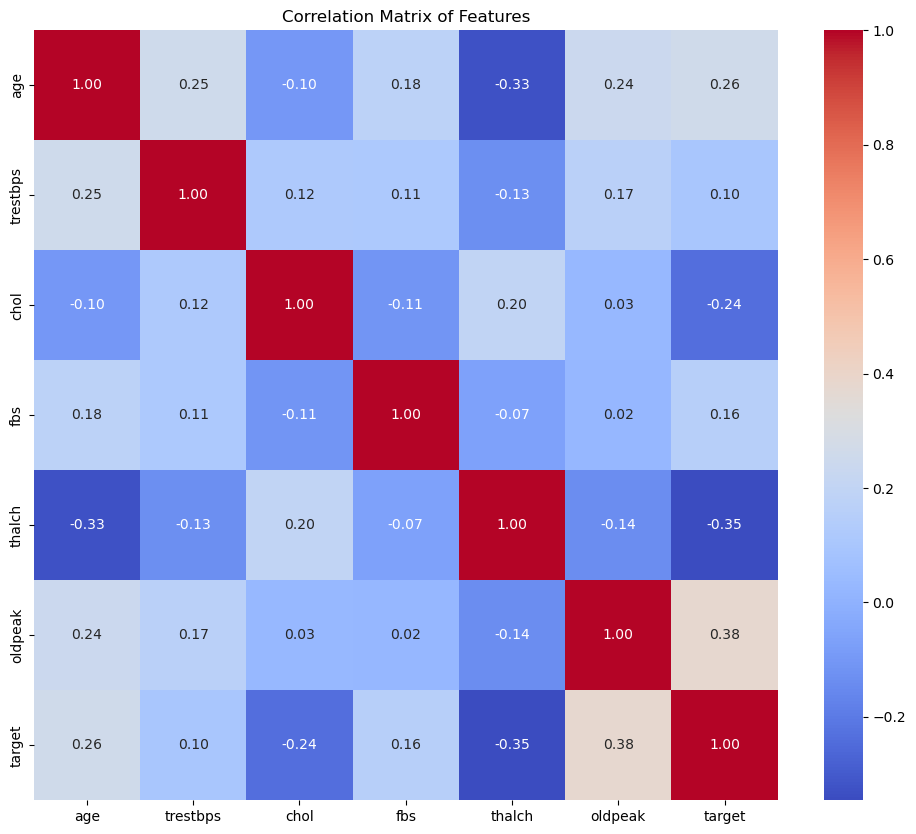


--- EDA: Target Variable Distribution ---


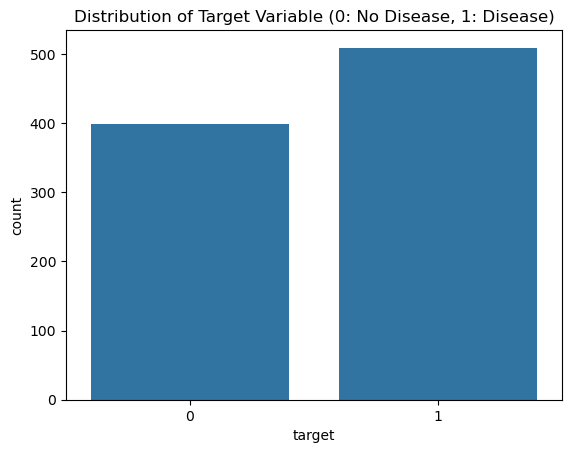

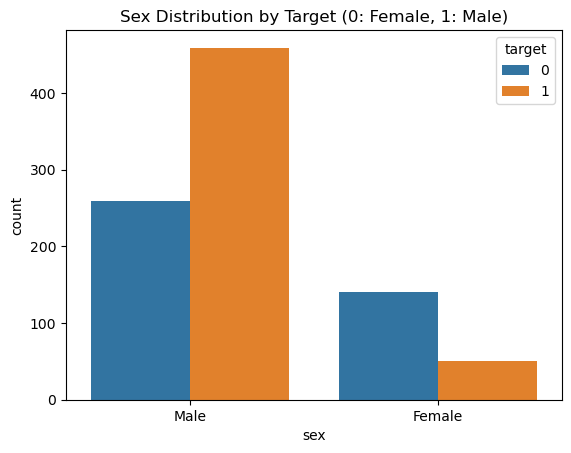

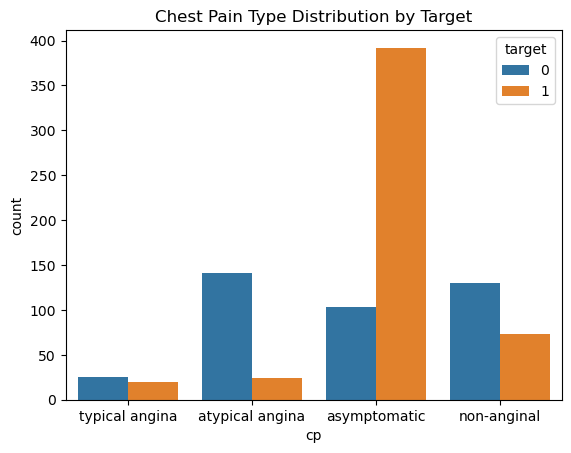

In [6]:
print("\n--- EDA: Checking for Missing Values ---")
print(df.isnull().sum())

# Visualizing missing values (optional)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

print("\n--- EDA: Basic Statistics ---")
print(df.describe())

print("\n--- EDA: Distribution of Features ---")
# Histograms for numerical features
df.hist(figsize=(15, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Box plots for numerical features (to identify outliers)
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.select_dtypes(include=np.number).columns):
    if col != 'target': # Don't plot target here
        plt.subplot(3, 5, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
plt.tight_layout()
plt.suptitle('Box Plots of Numerical Features (Outliers)', y=1.02)
plt.show()

print("\n--- EDA: Correlation Matrix ---")
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

print("\n--- EDA: Target Variable Distribution ---")
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable (0: No Disease, 1: Disease)')
plt.show()

# Example of categorical feature distribution (if any are not encoded yet)
# For 'sex'
sns.countplot(x='sex', hue='target', data=df)
plt.title('Sex Distribution by Target (0: Female, 1: Male)')
plt.show()

# For 'cp' (chest pain type)
sns.countplot(x='cp', hue='target', data=df)
plt.title('Chest Pain Type Distribution by Target')
plt.show()

3. Feature Engineering

In [7]:
# --- 3. Feature Engineering ---

print("\n--- Feature Engineering: Handling Missing Values ---")
# For simplicity, we'll fill missing numerical values with the mean
# And missing categorical values with the mode.
# Note: In a real scenario, more sophisticated imputation might be needed.

# Identify columns with missing values
missing_cols = df.columns[df.isnull().any()].tolist()
print(f"Columns with missing values: {missing_cols}")

for col in missing_cols:
    if df[col].dtype == 'object': # Categorical (like 'thal' in dummy data)
        # Fill with mode (most frequent value)
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")
    else: # Numerical
        # Fill with mean
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)
        print(f"Filled missing values in numerical column '{col}' with mean: {mean_val:.2f}")

print("\nMissing values after imputation:")
print(df.isnull().sum())

print("\n--- Feature Engineering: Encoding Categorical Variables ---")
# Identify categorical columns that need encoding (excluding the target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# Apply One-Hot Encoding to nominal categorical features (e.g., 'thal')
# For 'thal', the dummy data has 'fixed', 'normal', 'reversable' which are nominal.
# 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope' are often treated as categorical too,
# but can sometimes be left as numerical depending on interpretation.
# Let's treat sex, cp, fbs, restecg, exang, slope as categorical for one-hot encoding for robustness.

# Columns that are already numerical but represent categories (can be one-hot encoded)
# Or can be treated as ordinal by some models (like Decision Trees directly handle them)
# For Decision Trees, these can often be left as numerical unless there's a strong reason for one-hot.
# Let's one-hot encode them to be explicit about their non-ordinal nature (except for cp, slope if we assume some order)
# Let's encode sex, fbs, restecg, exang, thal for sure.
# cp, slope might be ordinal, but for safety in decision trees let's one-hot them too to avoid artificial ordering issues.
# For simplicity, let's treat these as nominal and one-hot encode them.
cols_to_onehot = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Filter out columns that don't exist in the df (e.g., if dummy data doesn't have all categorical columns)
cols_to_onehot = [col for col in cols_to_onehot if col in df.columns]

if cols_to_onehot:
    df = pd.get_dummies(df, columns=cols_to_onehot, drop_first=True, dtype=int) # drop_first avoids multicollinearity
    print("\nDataFrame after One-Hot Encoding:")
    print(df.head())
    print(f"New shape after encoding: {df.shape}")
else:
    print("No categorical columns identified for One-Hot Encoding.")


# Check final data types
print("\nFinal DataFrame info after Feature Engineering:")
df.info()


--- Feature Engineering: Handling Missing Values ---
Columns with missing values: ['oldpeak']
Filled missing values in numerical column 'oldpeak' with mean: 0.89

Missing values after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
target      0
dtype: int64

--- Feature Engineering: Encoding Categorical Variables ---
Categorical columns to encode: ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']

DataFrame after One-Hot Encoding:
   age  trestbps  chol  thalch  oldpeak  target  sex_Male  cp_atypical angina  \
0   63       145   233     150      2.3       0         1                   0   
1   41       135   203     132      0.0       0         1                   1   
2   57       140   192     148      0.4       0         1                   0   
3   52       118   186     190      0.0       0         1                   0   
4   57       110   201   

C:\Users\Admin\AppData\Local\Temp\ipykernel_22328\3372581106.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_val, inplace=True)


4. Decision Tree Classification


--- Decision Tree Classification ---
X_train shape: (726, 19)
X_test shape: (182, 19)
y_train distribution:
target
1    0.560606
0    0.439394
Name: proportion, dtype: float64
y_test distribution:
target
1    0.56044
0    0.43956
Name: proportion, dtype: float64

Training Decision Tree Classifier with default parameters...
Training complete.

--- Model Evaluation (Default Parameters) ---
Accuracy: 0.7473
Precision: 0.7642
Recall: 0.7941
F1-Score: 0.7788
ROC-AUC Score: 0.7408


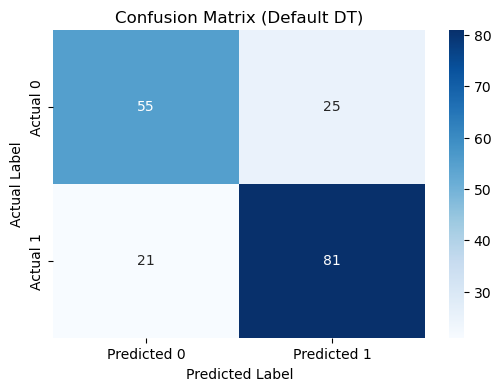

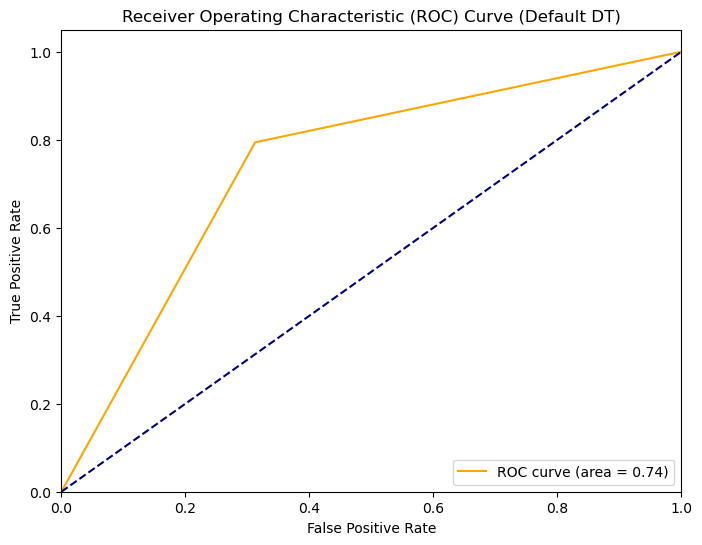

In [8]:
# --- 4. Decision Tree Classification ---

print("\n--- Decision Tree Classification ---")

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")

# Initialize the Decision Tree Classifier
# Using default parameters for initial training
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the training set
print("\nTraining Decision Tree Classifier with default parameters...")
dt_classifier.fit(X_train, y_train)
print("Training complete.")

# Predict on the testing set
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1] # Probabilities for ROC-AUC

# Evaluate model performance
print("\n--- Model Evaluation (Default Parameters) ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Default DT)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Default DT)')
plt.legend(loc="lower right")
plt.show()

5. Hyperparameter Tuning


In [9]:
# --- 5. Hyperparameter Tuning ---

print("\n--- Hyperparameter Tuning using GridSearchCV ---")

# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20], # None means unlimited depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'], # Consider a fraction of features
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1] # For post-pruning
}

# Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# scoring='roc_auc' because it's a good overall metric for binary classification
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1, # Use all available CPU cores
                           verbose=1)

# Fit GridSearchCV to the training data
print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete.")

# Get the best parameters and best score
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

# Get the best model
best_dt_classifier = grid_search.best_estimator_


--- Hyperparameter Tuning using GridSearchCV ---
Starting GridSearchCV...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
GridSearchCV complete.

Best parameters found: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation ROC-AUC score: 0.8367


6. Model Evaluation and Analysis (Tuned Model)



--- Model Evaluation (Tuned Model) ---
Tuned Model Accuracy: 0.7637
Tuned Model Precision: 0.7658
Tuned Model Recall: 0.8333
Tuned Model F1-Score: 0.7981
Tuned Model ROC-AUC Score: 0.8076


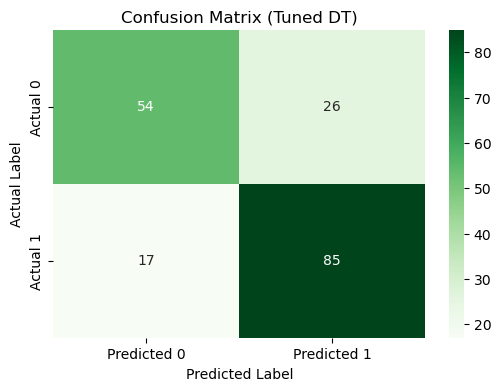

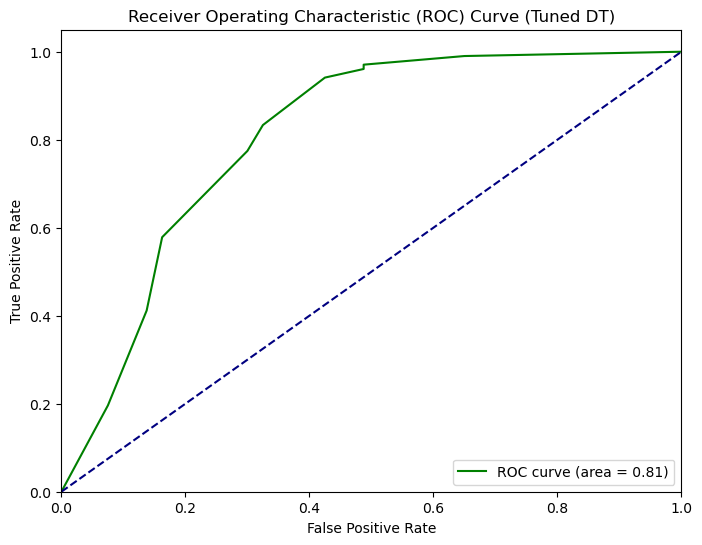


--- Feature Importance (Tuned Model) ---
exang_True                  0.394511
chol                        0.188687
oldpeak                     0.134552
thalch                      0.088731
age                         0.069610
cp_non-anginal              0.056210
cp_atypical angina          0.034565
sex_Male                    0.033134
trestbps                    0.000000
fbs_True                    0.000000
cp_typical angina           0.000000
restecg_normal              0.000000
restecg_st-t abnormality    0.000000
exang_FALSE                 0.000000
exang_TURE                  0.000000
slope_flat                  0.000000
slope_upsloping             0.000000
thal_normal                 0.000000
thal_reversable defect      0.000000
dtype: float64


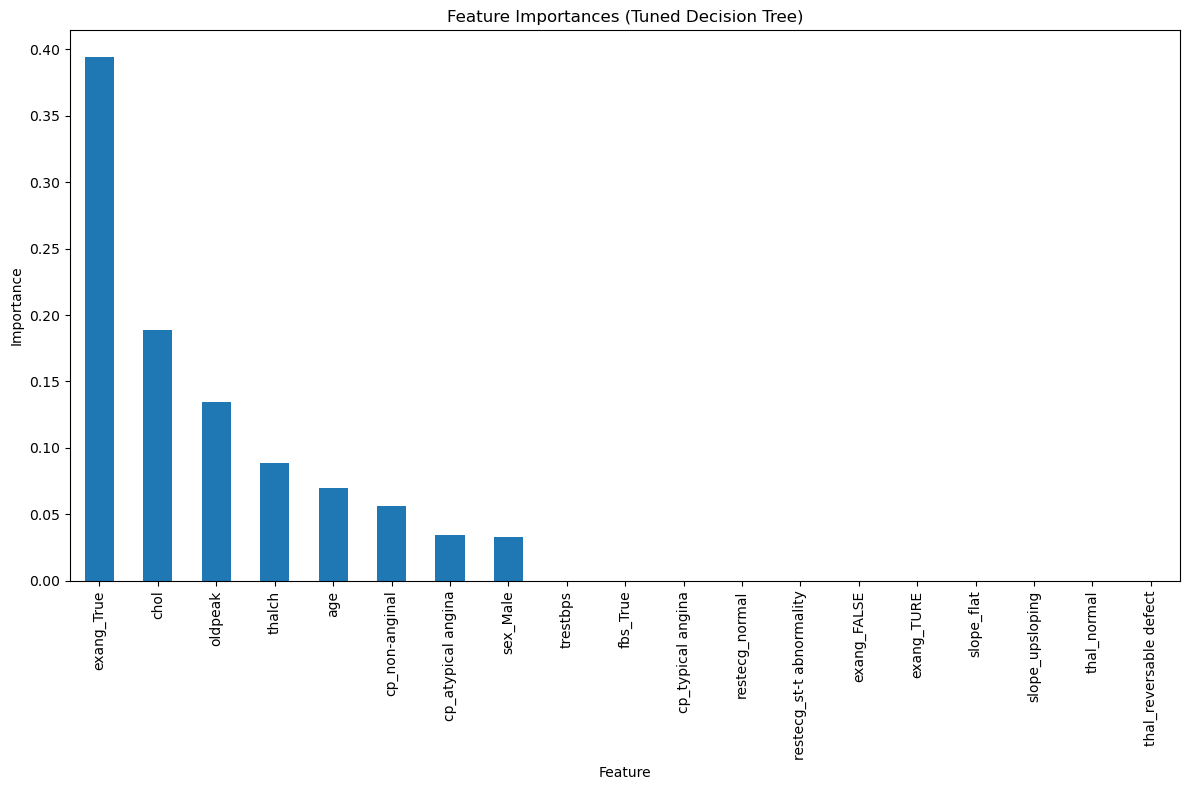


--- Visualizing the Decision Tree Structure (Tuned Model) ---


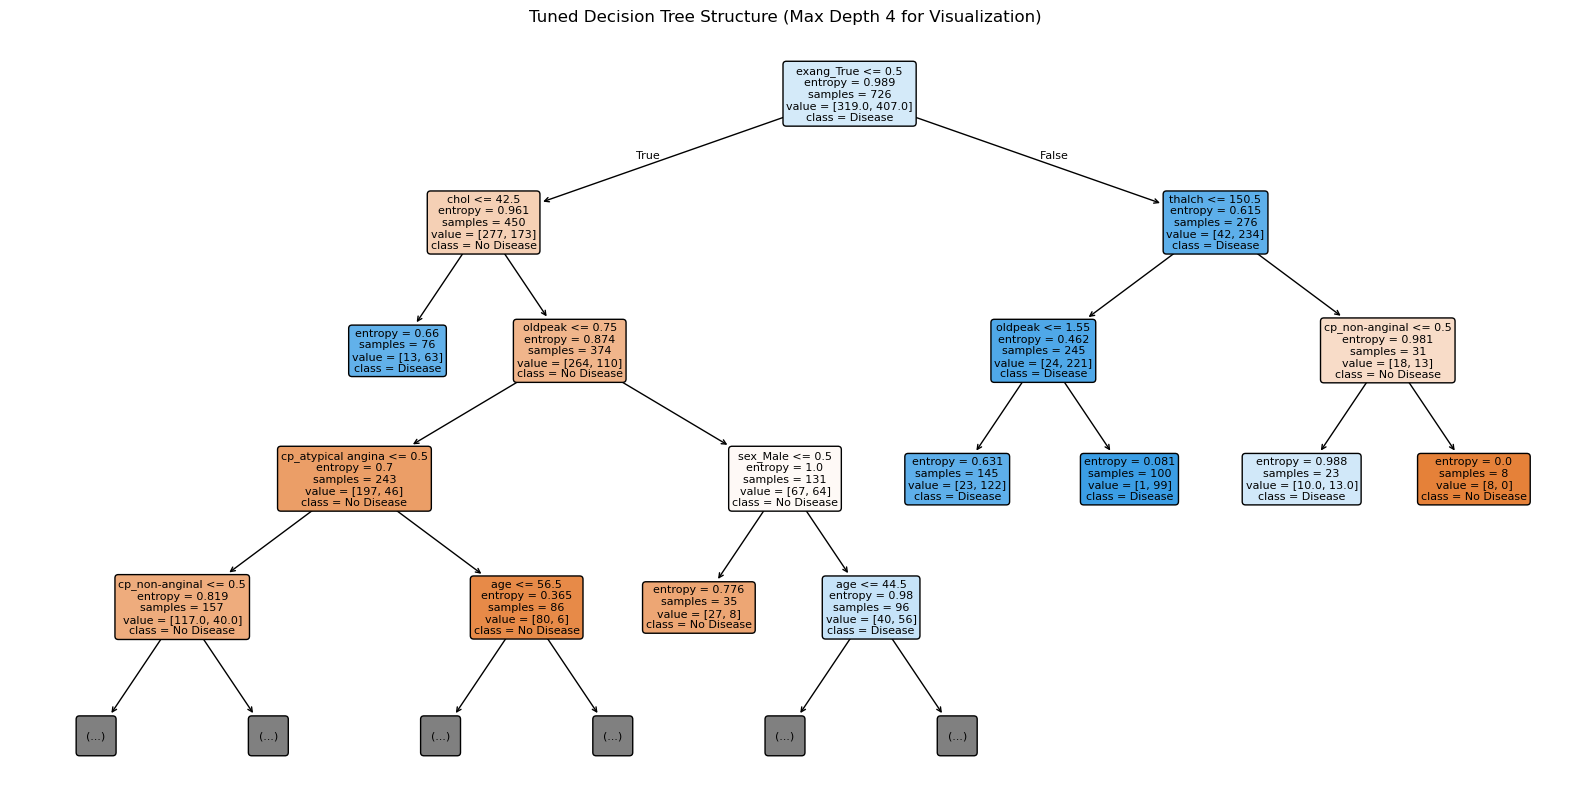


--- Interpretation of Results ---
The best Decision Tree model achieved a ROC-AUC score of 0.8076 on the test set.
The most important features for prediction, as identified by the model, are:
exang_True    0.394511
chol          0.188687
oldpeak       0.134552
thalch        0.088731
age           0.069610
dtype: float64
You can trace paths in the visualized tree to understand the decision rules. For example, a high 'thalch' (maximum heart rate achieved) and certain 'cp' (chest pain type) values often lead to a prediction of 'Disease'.


In [10]:
# --- 6. Model Evaluation and Analysis (Tuned Model) ---

print("\n--- Model Evaluation (Tuned Model) ---")

# Predict on the testing set using the best model
y_pred_tuned = best_dt_classifier.predict(X_test)
y_pred_proba_tuned = best_dt_classifier.predict_proba(X_test)[:, 1]

# Evaluate tuned model performance
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")
print(f"Tuned Model Precision: {precision_tuned:.4f}")
print(f"Tuned Model Recall: {recall_tuned:.4f}")
print(f"Tuned Model F1-Score: {f1_tuned:.4f}")
print(f"Tuned Model ROC-AUC Score: {roc_auc_tuned:.4f}")

# Confusion Matrix for Tuned Model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Tuned DT)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve for Tuned Model
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_proba_tuned)
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='green', label=f'ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned DT)')
plt.legend(loc="lower right")
plt.show()

print("\n--- Feature Importance (Tuned Model) ---")
feature_importances = pd.Series(best_dt_classifier.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

plt.figure(figsize=(12, 8))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances (Tuned Decision Tree)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Visualizing the Decision Tree Structure (Tuned Model) ---")
# Visualizing the tree can be resource-intensive for deep trees.
# We'll limit the depth for visualization to make it readable.
plt.figure(figsize=(20, 10))
plot_tree(best_dt_classifier,
          feature_names=X.columns.tolist(),
          class_names=['No Disease', 'Disease'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=4) # Limit depth for readability
plt.title('Tuned Decision Tree Structure (Max Depth 4 for Visualization)')
plt.show()

print("\n--- Interpretation of Results ---")
print(f"The best Decision Tree model achieved a ROC-AUC score of {roc_auc_tuned:.4f} on the test set.")
print("The most important features for prediction, as identified by the model, are:")
print(feature_importances.sort_values(ascending=False).head(5))
print("You can trace paths in the visualized tree to understand the decision rules. For example, a high 'thalch' (maximum heart rate achieved) and certain 'cp' (chest pain type) values often lead to a prediction of 'Disease'.")

Interview Questions:

**1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?**

Decision trees have several important hyperparameters that control their complexity and performance. The most common ones are:

max_depth – limits how deep the tree can grow. A shallow tree may underfit, while a very deep tree can overfit the training data.

min_samples_split – the minimum number of samples required to split a node. Higher values make the tree more general and reduce overfitting.

min_samples_leaf – minimum samples required at a leaf node. Increasing this helps prevent leaves with very few samples, improving generalization.

max_features – number of features considered for splitting at each node; lower values introduce randomness and may reduce overfitting.

criterion – the metric used to decide splits, such as gini or entropy.

By tuning these hyperparameters carefully, we can balance bias and variance to improve the model’s accuracy and generalization.

**2. What is the difference between the Label encoding and One-hot encoding?**

Label Encoding converts categorical values into numeric labels. For example, 'Red', 'Green', 'Blue' might be encoded as 0, 1, 2. This is suitable for ordinal categories where there is a natural order.

One-Hot Encoding, on the other hand, creates a separate binary column for each category. Using the same example, we would have three columns representing Red, Green, and Blue, with 1 indicating the presence of that category. This is preferred for nominal categories without order because it avoids introducing any false ordinal relationship.

In practice, One-Hot Encoding is safer for most algorithms, while Label Encoding is mainly for ordinal features.